# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импортируем необходимые библиотеки.
! pip install lightgbm
! pip install sweetviz
import lightgbm as lgb
import numpy as np
import pandas as pd
import sweetviz as sv
import time
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
warnings.filterwarnings("ignore")

In [2]:
# Импортируем и изучим данные
#df = pd.read_csv('/datasets/autos.csv')
df = pd.read_csv('autos.csv')
df.info()

In [3]:
df.head(10)

In [4]:
# Сделаем расширенный EDA-анализ
report = sv.analyze([df, " EDA-анализ данных"])
report.show_html('analysis.html')

In [5]:
df.describe()

Имеем 16 столбцов, 354 369 строк. Существуют пропуски некоторых данных.
- Столбец Price (цена в Евро) имеет нули. Необходимо удалить строки с нулевыми ценами.
- Столбец RegistrationYear (год регистрации авто) имеет годы более 2023 и 1000, что явно являются выбросами.
- Столбец Power (мощность в л.с.) имеет нули, а также очень большие значения - до 20000. Это нереально много.
- Столбец RegistrationMonth (месяц регистрации авто) имеет нули.
- Столбец NumberOfPictures (Количество фотографий автомобиля) - во всех строках значение 0, поэтому избавимся от этого столбца.

DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), LastSeen (дата последней активности пользователя) - данные колонки в обучении моделей нам не пригодятся, их можно будет удалить.

In [6]:
# Проверим на наличие дубликатов
df.duplicated().sum()

In [7]:
# Удалим явные дубликаты
df.drop_duplicates(inplace=True)

In [8]:
# Удалим колонки, не влияющие на дальнейшее обучение
df.drop(columns = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'RegistrationMonth'], inplace=True)

In [9]:
# Удаляем строки с нулевыми ценой, мощностью. 
df = df[df['Price'] != 0]
df = df[df['Power'] != 0]

In [10]:
# Удалим данные с годом регистрации до 1900 и после 2016 (максимальный год — дата скачивания анкеты (DateCrawled))
df = df[df['RegistrationYear'] >= 1900]
df = df[df['RegistrationYear'] <= 2016]

In [11]:
# Посмотрим количество пропусков по столбцам
print("Количество пропусков по столбцам \n", df.isnull().sum().sort_values(ascending = False))

Больше всего пропусков в столбце Repaired (Была машина в ремонте или нет) - 43074 шт.

Далее идут VehicleType (тип кузова), FuelType (тип топлива), Model (модель), Gearbox (тип коробки передач).

Восстановить данные не представляется возможным, поэтому заполним их константным значением "unknown".

In [13]:
# Заполним пропуски константным значением "unknown"
df['Repaired'] = df['Repaired'].fillna('unknown')
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')

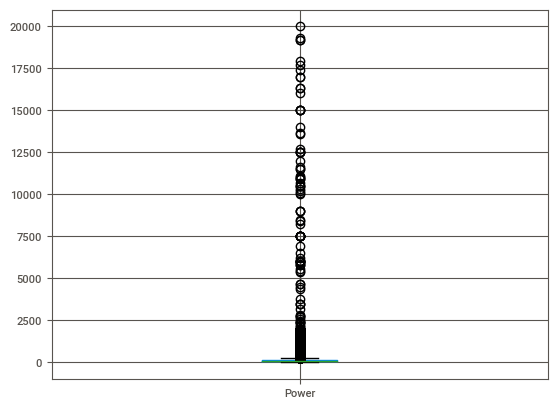

In [14]:
# Столбец Power (мощность в л.с.) имел слишком большие значения. Построим boxplot.
df.boxplot(column = 'Power')

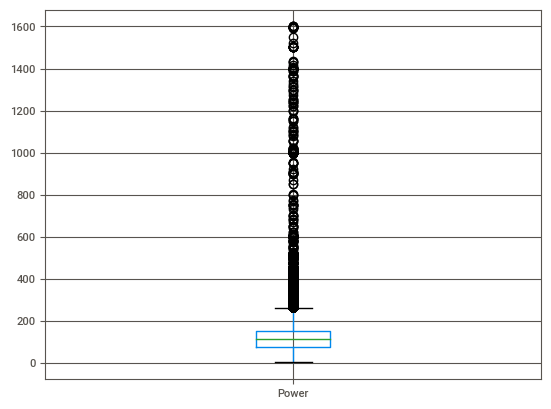

In [15]:
# В данных много выбросов. Т.к. самый мощный авто в мире имеет мощность 1600 л.с., удалим всё, что больше этой цифры.
df = df[df['Power'] <= 1600]
df.boxplot(column = 'Power')

In [16]:
df.shape

Было 16 столбцов, 354 369 строк, осталось 11 столбцов, 296 743 строк (84% от первоначального датасета).

Данные очищены, осталось закодировать категориальные признаки, выделить целевой признак, и разделить датасет на обучающую, валидационную и тестовую выборки

```python
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

In [17]:
# Выделим целевой признак
features = df.drop(['Price'], axis=1)
target = df['Price']

In [18]:
# Разобъем датасет на обучающую, валидационную и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [19]:
# Для кодирования категориальных признаков применим технику Ordinal Encoding
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [20]:
# Отмасштабируем числовые признаки методом стандартизации данных
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])

features_train = features_train_ord.copy()
features_valid = features_valid_ord.copy()
features_test = features_test_ord.copy()

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Выводы**
В первом разделе нами проделана следующая работа:
- Загружены необходимые библиотеки.
- Загружены данные.
- Изучены данные. Сделан расширенный EDA-анализ.
- Выявлено наличие пропусков в некоторых данных. Так как восстановить данные не представлялось возможным, заменили их на значение 'unknoun'.
- Выявили и удалили явные дубликаты.
- Удалили колонки, не влияющие на дальнейшее обучение.
- Удалили строки с нулевыми ценой, мощностью и месяцем.
- Удалили данные до 1900 года и после 2016 года (максимальный год скачивания анкеты)
- Удалили выбросы по столбцу Power (по мощности свыше 1600 л.с.).
- Для кодирования категориальных признаков применили технику Ordinal Encoding.
- Выделили целевой признак.
- Разбили датасет на обучающую, валидационную и тестовую выборки.
- Отмасштабировали числовые признаки, методом стандартизации данных.

Теперь наши данные готовы для обучения моделей.

## Обучение моделей

**LightGBM**

In [21]:
lgb_train = lgb.Dataset(features_train, target_train)
lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)

In [22]:
# Функция обучения модели LightGBM
def mod_train(parametrs):
    lgbm = lgb.train(parametrs, lgb_train, num_boost_round=40, valid_sets=lgb_valid, early_stopping_rounds=5)
    return lgbm

In [23]:
# Функция проверки предсказания и рассчёта RMSE
def rmse(model):
    targ_pred = model.predict(features_valid)
    print('RMSE:', mean_squared_error(target_valid, targ_pred) ** 0.5)

In [24]:
%%time
# обучим модель с настройками по умолчанию
param = {'metric': 'rmse', 'force_row_wise': True}
mod_train(param)

RMSE при обучении 1813.12, время обучения 0.89сек.

Попробуем разные гиперпараметры при обучении модели

In [25]:
%%time
# Попробуем менять скорость обучения
for i in np.arange(0.38, 0.4, 0.01):
    param = {'learning_rate':i, 'metric': 'rmse', 'force_row_wise': True}
    mod_train(param)  

Качество модели растёт с ростом скорости, но до значения 0.39 (RMSE: 1657.29), при дальнейшем повышении скорости качество ухудшается.

In [26]:
%%time
# Попробуем менять тип бустинга
types = ['gbrt', 'dart', 'goss']
for type in types:
    param = {'boosting_type': type, 'learning_rate':0.39, 'metric': 'rmse', 'force_row_wise': True}
    mod_train(param)    

Самый низкий RMSE (1657.29) в режиме по-умолчанию: 'gbrt' (дерево решений с градиентным бустингом)

In [27]:
%%time
# Попробуем менять глубину дерева и количество листьев
for i in range(12,15):
    param = {'max_depth':i, 'num_leaves':2**i, 'learning_rate':0.39, 'metric': 'rmse', 'force_row_wise': True, 'n_jobs':-1} 
    mod_train(param)   

RMSE улучшается до глубины 13 деревьев (количество листьев 8192), далее модель начинает работать хуже. Лучшее значение RMSE при этом: 1579.48.

In [28]:
%%time
# Теперь поиграем количеством деревьев
trees = [10, 50, 100, 500, 1000, 5000]
for i in trees:
    param = {'n_estimators':i, 'max_depth':13, 'num_leaves':8192, 'learning_rate':0.39, 'metric': 'rmse',
             'force_row_wise': True, 'n_jobs':-1}
    mod_train(param)    

Для нашего набора данных производительность улучшается до 32 деревьев (RMSE:1579.48).

In [29]:
%%time
# Попробуем модель с оптимальными настройками на основе проведённых исследований
param = {'n_estimators':32, 'max_depth':13, 'num_leaves':8192, 'learning_rate':0.39, 'metric': 'rmse',
         'force_row_wise': True, 'n_jobs':-1}
best_lgbm = mod_train(param)  

Точность обучения RMSE: 1579.48;
Время обучения: 3.45 сек.
Это лучшая модель

In [30]:
%%time
# Проверим предсказание и RMSE
rmse(best_lgbm)

Точность предсказания RMSE: 1579.48
Время предсказания: 0,34 сек

Итак, для модели "LightGBM", оптимальные настройки: 'boosting_type': 'gbrt', 'n_estimators': 32, 'max_depth': 13, 'num_leaves': 8192, 'learning_rate':0.39. RMSE тренировки и предсказания: 1579.48. Время тренировки: 3.45сек., время предсказания: 0,34сек.

**CatBoost**

In [31]:
# Функция обучения модели CatBoost
def catboost_train(parametrs):
    cbr = CatBoostRegressor(**parametrs)
    cb = cbr.fit(features_train, target_train, eval_set=(features_valid, target_valid))
    return cb

In [32]:
%%time
# обучим модель с настройками по умолчанию
param = {'loss_function':'RMSE', 'random_state': 12345}
catboost_train(param)

Точность на обучении RMSE: 1575.10
Время обучения: 47.7 сек.

In [33]:
%%time
# Попробуем менять принцип жадного алгоритма поиска.
gp = ['SymmetricTree', 'Depthwise', 'Lossguide']
for i in gp:
    param = {'grow_policy':i, 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

Лучшие показатели - в режиме "Depthwise" (дерево строится шаг за шагом, пока не достигнет нужной глубины, листья разделяются с использованием условия, приводящего к лушему уменьшению потерь). RMSE=1532.75, 999 итераций.

In [34]:
%%time
# Попробуем подобрать глубину деревьев
for i in range(11,14):
    param = {'depth':i, 'grow_policy':'Depthwise', 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

Самый низкий RMSE=1489,83 получился у нас при глубине 12, далее RMSE начал ухудшаться. Количество итераций 619.

In [35]:
%%time
# Попробуем подобрать скорость обучения
for i in np.arange(0.06, 0.08, 0.01):
    param = {'learning_rate':i, 'grow_policy':'Depthwise', 'depth':12, 'loss_function':'RMSE', 'random_state': 12345}
    catboost_train(param)    

При увеличении скорости обучения - RMSE уменьшается, до скорости 0,07 (RMSE=1482,82, 933 итерации), при дальнейшем увеличении скорости - RMSE ухудшается.

In [36]:
%%time
# Попробуем модель с оптимальными настройками на основе проведённых исследований
param = {'grow_policy':'Depthwise', 'depth':12, 'learning_rate':0.07, 'iterations':934, 'loss_function':'RMSE',
         'random_state': 12345}
best_catboost = catboost_train(param)

RMSE сохранилась (1482,82), скорость обучения 13 мин. 31 сек. Это лучшая модель.

Оптимальные параметры: 'grow_policy': 'Depthwise', 'depth': 12, 'learning_rate': 0.07, 'iterations': 934.

In [37]:
%%time
# Проверим предсказание и RMSE
rmse(best_catboost)

Точность предсказания RMSE: 1482.82
Время предсказания: 3.11 сек.

**SGDRegressor**

In [38]:
# Создаём модель
sgd = SGDRegressor(random_state=12345)

In [39]:
# создадим кросс-валидатор для последующего обучения моделей
cv = KFold(n_splits=3, shuffle=True, random_state=12345)

In [40]:
# Создадим словарь, в котором определим параметры модели, которые мы хотим передать через GridSearchCV,
# чтобы получить наилучшие параметры.
parameters = {'loss' : ['squared_loss', 'huber', 'epsilon_insensitive'],
              'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive'],
              'max_iter' : [i for i in range(121,124)],
              'penalty' : ['l2', 'l1', 'elasticnet']
             }

In [41]:
# Создаем объект grid_sgd для GridSearchCV и подгоняем набор данных
grid_sgd = GridSearchCV(estimator=sgd, param_grid = parameters, cv = cv, n_jobs=-1)

In [42]:
%%time
# Обучим grid_sgd
grid_sgd.fit(features_train, target_train)

In [43]:
# Отобразим результаты работы GridSearchCV
print("\n Лучшая оценка:\n", grid_sgd.best_score_)
print("\n Наилучшие параметры:\n", grid_sgd.best_params_)

In [44]:
%%time
# Применим найденные оптимальные настройки:
param = {'random_state':12345, 'loss':'epsilon_insensitive', 'learning_rate':'constant', 'penalty':'l1', 'max_iter':122}
sgd = SGDRegressor(**param)
best_sgd = sgd.fit(features_train, target_train)

In [53]:
%%time
rmse(best_sgd)

RMSE=3142.76, скорость обучения 3,66 сек., скорость предсказания 31 миллисекунда. Это лучшая модель.

Оптимальные параметры: 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'penalty': 'l1', 'max_iter': 122.

**Выводы**
В процессе исследования были применены 3 модели: LightGBM, CatBoost, SGDRegressor.
- LightGBM. Лучшие настройки: 'boosting_type': 'gbrt', 'n_estimators': 32, 'max_depth': 13, 'num_leaves': 8192, 'learning_rate':0.39. RMSE тренировки и предсказания: 1579.48. Время тренировки: 3.45сек., время предсказания: 0,34сек.
- CatBoost. Лучшие настройки: 'grow_policy': 'Depthwise', 'depth': 12, 'learning_rate': 0.07, 'iterations': 934. RMSE тренировки и предсказания: 1482.82. Время тренировки: 13 мин. 31 сек., время предсказания: 3.11сек.
- SGDRegressor. Лучшие настройки: 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'penalty': 'l1', 'max_iter': 122. RMSE тренировки и предсказания: 3142.70. Время тренировки: 3.66 сек., время предсказания: 31 миллисекунда.

## Анализ моделей

In [54]:
# Запишем данные всех моделей вместе
models = []
models.append([1579.48, 3.45, 0.34])
models.append([1482.82, 811.0, 3.11])
models.append([3142.70, 3.66, 0.31])

In [55]:
model_table = pd.DataFrame(data=models, index=['LightGBM', 'CatBoost', 'SGDRegressor'],
                           columns=['RMSE', 'Время тренировки', 'Время предсказания'])

In [56]:
model_table

**Выводы**
Самое лучшее RMSE - у модели CatBoost (1482,82), но модель работает очень медленно по сравнению с остальными, как при тренировке, так и при предсказании. Модель LightGBM имеет чуть хуже RMSE (1579,48), но незначительно. Зато данная модель показывает хорошие результаты по быстродействию (время тренировки 3,45сек., время предсказания 0,34 сек.), поэтому в качестве лучшей модели рекомендую её.

## Тестирование лучшей модели

Проверим качество данной модели на тестовой выборке:

In [57]:
print('RMSE модели LightGBM на тестовой выборке:', mean_squared_error(target_test, best_lgbm.predict(features_test)) ** 0.5)

**Вывод**
RMSE рекомендуемой нами модели LightGBM на тестовой выборке: 1600.78. Немного хуже, чем на валидационной (1579,48), но значение допустимо, и не превышает требования в задании (RMSE не должно превышать 2500). Рекомендую заказчику данную модель для использования.